### Code For Mounting personal Google Drive on Colab

In [46]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive  -o nonempty

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


-------------

# Import Package

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
from sklearn.utils import shuffle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

# Training Data

## Step1: Data Generate


* padding number1 & 2 to three digits (because number1 & number2 are less than 1000)
* accepted operator **+** **-** (0: + / 1: -) 
----
* input format : 
    
    **number1 [3]** + **number2 [3]** + **operator [1]** 
* example:

    * 52 + 774  :  052 774 0
    * 692 - 3  : 692 003 1
----
* output fornat : I also padding answer to four digits

    **answer [4]** + **plus-mins sign [1]**
* example

    * 1313 : 1313 0
    * -691: 0691 1


In [0]:
def genTrainData(dataSize):
    ################################################
    
    #    params:
    #        dataSize: generate trainData size      
    #    
    #    return: 
    #        train_X: input data
    #        train_Y: output data
    
    ################################################
    
    train_X = []
    train_Y = []
    tmp = []

    for i in range(int(dataSize/2)):
        a = rd.randint(0, 999)
        b = rd.randint(0, 999)
        str_a = str(a).zfill(3)
        str_b = str(b).zfill(3)
        list_of_a = [int(i) for i in str_a]
        list_of_b = [int(i) for i in str_b]

        tmp = list_of_a + list_of_b
        tmp.append(0)
        train_X.append(tmp)

        ans = a + b
        str_ans = str(ans).zfill(4)
        list_of_ans = [int(i) for i in str_ans]
        list_of_ans.append(0)
        train_Y.append(list_of_ans)

    for i in range(int(dataSize/2)): 
        a = rd.randint(0, 999)
        b = rd.randint(0, 999)
        str_a = str(a).zfill(3)
        str_b = str(b).zfill(3)
        list_of_a = [int(i) for i in str_a]
        list_of_b = [int(i) for i in str_b]

        tmp = list_of_a + list_of_b
        tmp.append(1)
        train_X.append(tmp)

        ans = a - b
        str_ans = str(abs(ans)).zfill(4)
        list_of_ans = [int(i) for i in str_ans]
        if ans < 0:
            list_of_ans.append(1)
        else:
            list_of_ans.append(0)
        train_Y.append(list_of_ans)
    
    pd.DataFrame(train_X, columns = ['num1(100)', 'num1(10)', 'num1(1)', 'num2(100)', 'num2(10)', 'num2(1)', '+/-']).to_csv("./data/train_X.csv", sep=',')
    pd.DataFrame(train_Y, columns = ['ans(1000)', 'ans(100)', 'ans(10)', 'ans(1)', '+/-']).to_csv("./data/train_Y.csv", sep=',')

In [0]:
def loadTrainData():
    train_X = pd.read_csv("./data/train_X.csv")
    train_Y = pd.read_csv("./data/train_Y.csv")
    
    X = train_X.loc[:, train_X.columns[1:]].values.tolist()
    Y = train_Y.loc[:, train_Y.columns[1:]].values.tolist()
    
    return X, Y

## Step2: One-Hot Encoding

* example
    52 + 774 : 052 0 774
  
  * 0 : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  * 5 : [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
  * 2 : [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
  * 0 : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  * 7 : [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
  * 7 : [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
  * 4 : [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  
* input dim : **[1 x 7]**
* output dim : **[10 x 7]**
    

In [0]:
def encoding(data):    
    ################################################
    
    #    params:
    #        data: original input data      
    #    
    #    return: 
    #        encoded: data after one-hot encoding 
    
    ################################################
    
    encoded = to_categorical(data)
    return encoded

## Step3: Flatten

flatten input data to one dimension array
* input dim : [10 x 7]
* output dim : **[1 x 70]  (Model Input Dimension)**

In [0]:
def flatten(data):    
    ################################################
    
    #    params:
    #        data: original input data      
    #    
    #    return: 
    #        encoded: data after flattening
    
    ################################################
    
    flatten = data.reshape(len(data), -1)
    return flatten

---------------------------------

# Testing Data

In [0]:
def genTestData(dataSize):
    test_X = []
    test_Y = []
    tmp = []

    for i in range(int(dataSize/2)):
        a = rd.randint(0, 999)
        b = rd.randint(0, 999)
        str_a = str(a).zfill(3)
        str_b = str(b).zfill(3)
        list_of_a = [int(i) for i in str_a]
        list_of_b = [int(i) for i in str_b]

        tmp = list_of_a + list_of_b
        tmp.append(0)
        test_X.append(tmp)

        ans = a + b
        str_ans = str(ans).zfill(4)
        list_of_ans = [int(i) for i in str_ans]
        list_of_ans.append(0)
        test_Y.append(list_of_ans)

    for i in range(int(dataSize/2)):
        a = rd.randint(0, 999)
        b = rd.randint(0, 999)
        str_a = str(a).zfill(3)
        str_b = str(b).zfill(3)
        list_of_a = [int(i) for i in str_a]
        list_of_b = [int(i) for i in str_b]

        tmp = list_of_a + list_of_b
        tmp.append(1)
        test_X.append(tmp)

        ans = a - b
        str_ans = str(abs(ans)).zfill(4)
        list_of_ans = [int(i) for i in str_ans]
        if ans < 0:
            list_of_ans.append(1)
        else:
            list_of_ans.append(0)
        test_Y.append(list_of_ans)
    
    pd.DataFrame(test_X, columns = ['num1(100)', 'num1(10)', 'num1(1)', 'num2(100)', 'num2(10)', 'num2(1)', '+/-']).to_csv("./data/test_X.csv", sep=',')
    pd.DataFrame(test_Y, columns = ['ans(1000)', 'ans(100)', 'ans(10)', 'ans(1)', '+/-']).to_csv("./data/test_Y.csv", sep=',')

In [0]:
def loadTestData():
    train_X = pd.read_csv("./data/test_X.csv")
    train_Y = pd.read_csv("./data/test_Y.csv")
    
    X = train_X.loc[:, train_X.columns[1:]].values.tolist()
    Y = train_Y.loc[:, train_Y.columns[1:]].values.tolist()
    
    return X, Y

-------------------------

# Model

<p style="text-align:center;"> 
  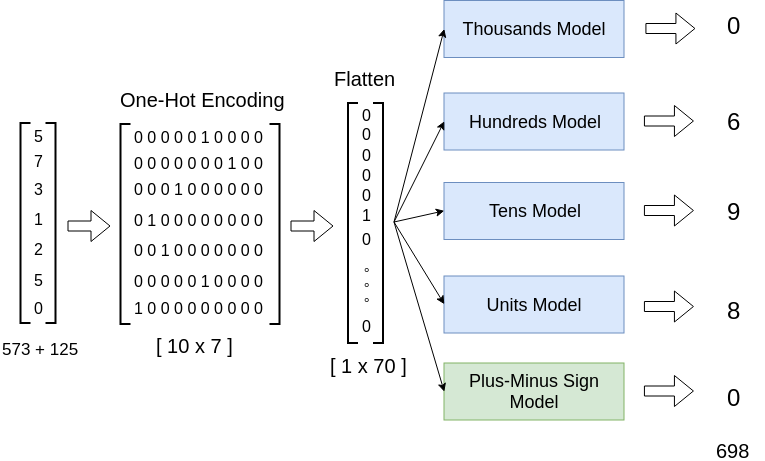 
</p>

## Construction

Build models of each digits (including **thousands**, **hundreds**, **tens**, **units**, **plus-minus sign**) 

In [0]:
def modelConstruction(train_X, train_Y):
    ################################################
    
    #    params:
    #        train_X: model training input      
    #        train_Y: model training output
    
    ################################################
    
    train_Y_thou = train_Y[:, 0, :]
    model_thou = Sequential()
    model_thou.add(Dense(70 , input_shape=(70,), activation='relu'))
    model_thou.add(Dense(35, activation='relu'))
    model_thou.add(Dense(10, activation='sigmoid'))
    model_thou.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("train model of thousands digit ...")
    model_thou.fit(train_X, train_Y_thou, batch_size=128, validation_split=0.2, shuffle=True, verbose=1, epochs=75)
    
    train_Y_hun = train_Y[:, 1, :]
    model_hun = Sequential()
    model_hun.add(Dense(250 , input_shape=(70,), activation='relu'))
    model_hun.add(Dense(250, activation='relu'))
    model_hun.add(Dense(150, activation='relu'))
    model_hun.add(Dense(50, activation='relu'))
    model_hun.add(Dense(10, activation='sigmoid'))
    model_hun.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("train model of hundreds digit ...")
    model_hun.fit(train_X, train_Y_hun, batch_size=128, validation_split=0.2, shuffle=True, verbose=1, epochs=100)
    
    train_Y_ten = train_Y[:, 2, :]
    model_ten = Sequential()
    model_ten.add(Dense(250 , input_shape=(70,), activation='relu'))
    model_ten.add(Dense(250, activation='relu'))
    model_ten.add(Dense(150, activation='relu'))
    model_ten.add(Dense(50, activation='relu'))
    model_ten.add(Dense(10, activation='sigmoid'))
    model_ten.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("train model of tens digit ...")
    model_ten.fit(train_X, train_Y_ten, batch_size=128, validation_split=0.2, shuffle=True, verbose=1, epochs=100)
    
    train_Y_unit = train_Y[:, 3, :]
    model_unit = Sequential()
    model_unit.add(Dense(250 , input_shape=(70,), activation='relu'))
    model_unit.add(Dense(250, activation='relu'))
    model_unit.add(Dense(150, activation='relu'))
    model_unit.add(Dense(50, activation='relu'))
    model_unit.add(Dense(10, activation='sigmoid'))
    model_unit.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("train model of units digit ...")
    model_unit.fit(train_X, train_Y_unit, batch_size=128, validation_split=0.2, shuffle=True, verbose=1, epochs=100)
    
    train_Y_sym = train_Y[:, 4, :2]
    model_sym = Sequential()
    model_sym.add(Dense(250 , input_shape=(70,), activation='relu'))
    model_sym.add(Dense(250, activation='relu'))
    model_sym.add(Dense(150, activation='relu'))
    model_sym.add(Dense(50, activation='relu'))
    model_sym.add(Dense(2, activation='sigmoid'))
    model_sym.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("train model of plus-minus sign ...")
    model_sym.fit(train_X, train_Y_sym, batch_size=128, validation_split=0.2, shuffle=True, verbose=1, epochs=50)

    model_dir = "./model/"
    model_thou.model.save(model_dir + "thousand.h5")
    model_hun.model.save(model_dir + "hundred.h5")
    model_ten.model.save(model_dir + "ten.h5")
    model_unit.model.save(model_dir + "unit.h5")
    model_sym.model.save(model_dir + "symbol.h5")

In [0]:
def loadModel():
    model_dir = "./model/"
    
    model_thou = load_model(model_dir + "thousand.h5")
    model_hun = load_model(model_dir + "hundred.h5")
    model_ten = load_model(model_dir + "ten.h5")
    model_unit = load_model(model_dir + "unit.h5")
    model_sym = load_model(model_dir + "symbol.h5")
    
    return model_thou, model_hun, model_ten, model_unit, model_sym

## Validation

plot the classfication result of each models

In [0]:
def plot_confusion_matrix(model, X, y, name):
    y_pred = np.argmax(model.predict(X, verbose=0), axis = 1)
    plt.figure(figsize=(8, 6))
    plt.title(name + " validation result")
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

In [0]:
def modelValidation(test_X, test_Y):
    model_thou, model_hun, model_ten, model_unit, model_sym = loadModel()
    
    plot_confusion_matrix(model_thou, np.array(test_X), np.array(test_Y)[:, 0], "thousands model")
    plot_confusion_matrix(model_hun, np.array(test_X), np.array(test_Y)[:, 1], "hundreds model")
    plot_confusion_matrix(model_ten, np.array(test_X), np.array(test_Y)[:, 2], "tens model")
    plot_confusion_matrix(model_unit, np.array(test_X), np.array(test_Y)[:, 3], "units model")
    plot_confusion_matrix(model_sym, np.array(test_X), np.array(test_Y)[:, 4], "plus-minus sign model")
    

# Data Representation

print the input data and output answer, and then show the correction or error

In [0]:
def dataRepresentation(test):    
    model_thou, model_hun, model_ten, model_unit, model_sym = loadModel()
  
    rd.shuffle(test)
    inputs = []
    actual = []
    for it in test:
        int1 = int(str(it[0]) + str(it[1]) + str(it[2]))
        int2 = int(str(it[3]) + str(it[4]) + str(it[5]))
        if it[6] == 0:
            symbol = '+'
            actual.append(int1 + int2)
        else:
            symbol = '-'
            actual.append(int1 - int2)

        input = str(int1) + symbol + str(int2)
        inputs.append(input)
    
    test_X = to_categorical(test).reshape(len(test), -1)
    thou_pred = np.argmax(model_thou.predict(test_X, verbose=0), axis = 1)
    hun_pred = np.argmax(model_hun.predict(test_X, verbose=0), axis = 1)
    ten_pred = np.argmax(model_ten.predict(test_X, verbose=0), axis = 1)
    unit_pred = np.argmax(model_unit.predict(test_X, verbose=0), axis = 1)
    sym_pred = np.argmax(model_sym.predict(test_X, verbose=0), axis = 1)

    predict = []
    for i in range(len(sym_pred)):
        if sym_pred[i] == 0:
            ans = 1
        else:
            ans = -1

        ans *= int(str(thou_pred[i]) + str(hun_pred[i]) + str(ten_pred[i]) + str(unit_pred[i]))
        predict.append(ans)
        
    correct = 0
    err = 0
    for i in range(len(actual)):
        if(actual[i] != predict[i]):
            err += 1
        else:
            correct += 1
    
    for i in range(10):
        if(actual[i] != predict[i]):
            print("%10s  \t [x]%6d" % (inputs[i], predict[i]))
        else:
            print("%10s  \t [o]%6d" % (inputs[i], predict[i]))
    
    accuracy = float(correct) / float(len(test)) * 100
    print ("Accuracy : %.2f %%" % accuracy)
    print ("Error times : %d / %d" % (err, len(test_X)))

-------------------------

# Main

In [170]:
# Get the training data
train_X, train_Y = loadTrainData()
train = train_X
train_X = flatten(encoding(train_X))
train_Y = encoding(train_Y)

# Train models
modelConstruction(train_X, train_Y)

train model of thousands digit ...
Train on 80000 samples, validate on 20000 samples
Epoch 1/75
80000/80000 [==============================] - 13s 162us/step - loss: 0.3355 - acc: 0.8449 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 2/75
80000/80000 [==============================] - 5s 69us/step - loss: 0.0250 - acc: 0.9918 - val_loss: 1.9914e-04 - val_acc: 1.0000
Epoch 3/75
80000/80000 [==============================] - 5s 68us/step - loss: 0.0152 - acc: 0.9952 - val_loss: 7.2712e-05 - val_acc: 1.0000
Epoch 4/75
14208/80000 [====>.........................] - ETA: 4s - loss: 0.0107 - acc: 0.997080000/80000 [==============================] - 5s 67us/step - loss: 0.0094 - acc: 0.9972 - val_loss: 2.5266e-05 - val_acc: 1.0000
Epoch 5/75
80000/80000 [==============================] - 5s 68us/step - loss: 0.0066 - acc: 0.9979 - val_loss: 7.3814e-06 - val_acc: 1.0000
Epoch 6/75
80000/80000 [==============================] - 5s 68us/step - loss: 0.0061 - acc: 0.9978 - val_loss: 8.4971e-06 - val_

70272/80000 [=========================>....] - ETA: 0s - loss: 6.1758e-04 - acc: 0.999880000/80000 [==============================] - 5s 67us/step - loss: 5.7898e-04 - acc: 0.9998 - val_loss: 1.2766e-07 - val_acc: 1.0000
Epoch 50/75
80000/80000 [==============================] - 5s 67us/step - loss: 0.0017 - acc: 0.9994 - val_loss: 1.1948e-07 - val_acc: 1.0000
Epoch 51/75
80000/80000 [==============================] - 5s 67us/step - loss: 3.9140e-04 - acc: 0.9999 - val_loss: 1.1962e-07 - val_acc: 1.0000
Epoch 52/75
70016/80000 [=========================>....] - ETA: 0s - loss: 1.2606e-04 - acc: 1.000080000/80000 [==============================] - 5s 67us/step - loss: 1.1836e-04 - acc: 1.0000 - val_loss: 1.1960e-07 - val_acc: 1.0000
Epoch 53/75
80000/80000 [==============================] - 5s 67us/step - loss: 0.0013 - acc: 0.9996 - val_loss: 1.2079e-07 - val_acc: 1.0000
Epoch 54/75
80000/80000 [==============================] - 5s 67us/step - loss: 7.9900e-04 - acc: 0.9997 - val_loss:

47360/80000 [================>.............] - ETA: 2s - loss: 0.0220 - acc: 0.992480000/80000 [==============================] - 6s 81us/step - loss: 0.0233 - acc: 0.9920 - val_loss: 0.1487 - val_acc: 0.9553
Epoch 23/100
80000/80000 [==============================] - 6s 80us/step - loss: 0.0190 - acc: 0.9934 - val_loss: 0.1208 - val_acc: 0.9641
Epoch 24/100
80000/80000 [==============================] - 6s 80us/step - loss: 0.0214 - acc: 0.9925 - val_loss: 0.1129 - val_acc: 0.9670
Epoch 25/100
47232/80000 [================>.............] - ETA: 2s - loss: 0.0182 - acc: 0.993880000/80000 [==============================] - 6s 81us/step - loss: 0.0195 - acc: 0.9935 - val_loss: 0.0768 - val_acc: 0.9749
Epoch 26/100
80000/80000 [==============================] - 6s 80us/step - loss: 0.0199 - acc: 0.9936 - val_loss: 0.0901 - val_acc: 0.9726
Epoch 27/100
80000/80000 [==============================] - 6s 80us/step - loss: 0.0159 - acc: 0.9946 - val_loss: 0.1034 - val_acc: 0.9673
Epoch 28/100


47360/80000 [================>.............] - ETA: 2s - loss: 0.0081 - acc: 0.997780000/80000 [==============================] - 6s 80us/step - loss: 0.0068 - acc: 0.9980 - val_loss: 0.0405 - val_acc: 0.9904
Epoch 74/100
80000/80000 [==============================] - 6s 79us/step - loss: 0.0053 - acc: 0.9986 - val_loss: 0.0435 - val_acc: 0.9886
Epoch 75/100
80000/80000 [==============================] - 6s 80us/step - loss: 0.0038 - acc: 0.9989 - val_loss: 0.0334 - val_acc: 0.9922
Epoch 76/100
48896/80000 [=================>............] - ETA: 2s - loss: 0.0028 - acc: 0.999280000/80000 [==============================] - 6s 80us/step - loss: 0.0030 - acc: 0.9992 - val_loss: 0.0525 - val_acc: 0.9851
Epoch 77/100
80000/80000 [==============================] - 6s 81us/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0250 - val_acc: 0.9939
Epoch 78/100
80000/80000 [==============================] - 6s 81us/step - loss: 0.0115 - acc: 0.9971 - val_loss: 0.0651 - val_acc: 0.9851
Epoch 79/100


46336/80000 [================>.............] - ETA: 2s - loss: 0.0149 - acc: 0.995480000/80000 [==============================] - 7s 82us/step - loss: 0.0111 - acc: 0.9966 - val_loss: 0.0235 - val_acc: 0.9918
Epoch 25/100
80000/80000 [==============================] - 7s 82us/step - loss: 0.0047 - acc: 0.9987 - val_loss: 0.0187 - val_acc: 0.9936
Epoch 26/100
80000/80000 [==============================] - 7s 82us/step - loss: 0.0064 - acc: 0.9982 - val_loss: 0.2553 - val_acc: 0.9341
Epoch 27/100
45056/80000 [===============>..............] - ETA: 2s - loss: 0.0206 - acc: 0.993780000/80000 [==============================] - 7s 83us/step - loss: 0.0138 - acc: 0.9957 - val_loss: 0.0241 - val_acc: 0.9926
Epoch 28/100
80000/80000 [==============================] - 6s 81us/step - loss: 0.0020 - acc: 0.9994 - val_loss: 0.0167 - val_acc: 0.9945
Epoch 29/100
80000/80000 [==============================] - 7s 82us/step - loss: 0.0161 - acc: 0.9951 - val_loss: 0.0414 - val_acc: 0.9871
Epoch 30/100


37504/80000 [=============>................] - ETA: 3s - loss: 1.2488e-07 - acc: 1.000080000/80000 [==============================] - 6s 81us/step - loss: 1.2476e-07 - acc: 1.0000 - val_loss: 9.7139e-04 - val_acc: 0.9998
Epoch 73/100
80000/80000 [==============================] - 7s 82us/step - loss: 1.2306e-07 - acc: 1.0000 - val_loss: 9.3306e-04 - val_acc: 0.9999
Epoch 74/100
80000/80000 [==============================] - 7s 82us/step - loss: 1.2187e-07 - acc: 1.0000 - val_loss: 9.3319e-04 - val_acc: 0.9999
Epoch 75/100
35968/80000 [============>.................] - ETA: 3s - loss: 1.2105e-07 - acc: 1.000080000/80000 [==============================] - 7s 82us/step - loss: 1.2101e-07 - acc: 1.0000 - val_loss: 9.0518e-04 - val_acc: 0.9999
Epoch 76/100
80000/80000 [==============================] - 7s 82us/step - loss: 1.2043e-07 - acc: 1.0000 - val_loss: 9.0706e-04 - val_acc: 0.9999
Epoch 77/100
80000/80000 [==============================] - 7s 82us/step - loss: 1.2003e-07 - acc: 1.000

46464/80000 [================>.............] - ETA: 2s - loss: 0.0043 - acc: 0.998780000/80000 [==============================] - 7s 82us/step - loss: 0.0045 - acc: 0.9986 - val_loss: 0.0433 - val_acc: 0.9884
Epoch 21/100
80000/80000 [==============================] - 7s 83us/step - loss: 0.0063 - acc: 0.9980 - val_loss: 0.0473 - val_acc: 0.9871
Epoch 22/100
80000/80000 [==============================] - 7s 82us/step - loss: 0.0026 - acc: 0.9993 - val_loss: 0.0335 - val_acc: 0.9899
Epoch 23/100
45184/80000 [===============>..............] - ETA: 2s - loss: 0.0039 - acc: 0.998880000/80000 [==============================] - 7s 81us/step - loss: 0.0046 - acc: 0.9985 - val_loss: 0.0427 - val_acc: 0.9885
Epoch 24/100
80000/80000 [==============================] - 7s 81us/step - loss: 0.0043 - acc: 0.9986 - val_loss: 0.0538 - val_acc: 0.9853
Epoch 25/100
80000/80000 [==============================] - 7s 82us/step - loss: 0.0030 - acc: 0.9990 - val_loss: 0.0370 - val_acc: 0.9885
Epoch 26/100


42496/80000 [==============>...............] - ETA: 2s - loss: 1.2181e-04 - acc: 1.000080000/80000 [==============================] - 7s 82us/step - loss: 1.1045e-04 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9942
Epoch 72/100
80000/80000 [==============================] - 7s 82us/step - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0424 - val_acc: 0.9923
Epoch 73/100
80000/80000 [==============================] - 7s 82us/step - loss: 0.0038 - acc: 0.9993 - val_loss: 0.0386 - val_acc: 0.9920
Epoch 74/100
42368/80000 [==============>...............] - ETA: 2s - loss: 0.0025 - acc: 0.999480000/80000 [==============================] - 7s 82us/step - loss: 0.0023 - acc: 0.9995 - val_loss: 0.0281 - val_acc: 0.9938
Epoch 75/100
80000/80000 [==============================] - 7s 82us/step - loss: 0.0012 - acc: 0.9997 - val_loss: 0.0559 - val_acc: 0.9887
Epoch 76/100
80000/80000 [==============================] - 7s 82us/step - loss: 0.0028 - acc: 0.9994 - val_loss: 0.0297 - val_acc: 0.9943
Epoch

44672/80000 [===============>..............] - ETA: 2s - loss: 0.0010 - acc: 0.999680000/80000 [==============================] - 7s 82us/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0113 - val_acc: 0.9962
Epoch 20/50
80000/80000 [==============================] - 7s 82us/step - loss: 5.9551e-04 - acc: 0.9998 - val_loss: 0.0215 - val_acc: 0.9928
Epoch 21/50
80000/80000 [==============================] - 7s 82us/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0114 - val_acc: 0.9962
Epoch 22/50
43392/80000 [===============>..............] - ETA: 2s - loss: 8.4168e-04 - acc: 0.999780000/80000 [==============================] - 7s 82us/step - loss: 9.7036e-04 - acc: 0.9997 - val_loss: 0.0124 - val_acc: 0.9966
Epoch 23/50
80000/80000 [==============================] - 7s 82us/step - loss: 5.6049e-04 - acc: 0.9998 - val_loss: 0.0168 - val_acc: 0.9959
Epoch 24/50
80000/80000 [==============================] - 7s 83us/step - loss: 7.0992e-04 - acc: 0.9998 - val_loss: 0.0181 - val_acc: 0.995

Training Data: 
   940-412  	 [o]   528
   116-472  	 [o]  -356
   835-977  	 [o]  -142
   345+989  	 [o]  1334
   881-341  	 [o]   540
   498+582  	 [o]  1080
   480-459  	 [x]   -21
   781-520  	 [o]   261
   105-861  	 [o]  -756
   499+667  	 [o]  1166
Accuracy : 99.78 %
Error times : 218 / 100000

Validation Data: 
   806+964  	 [o]  1770
   678-678  	 [o]     0
   943-328  	 [o]   615
   352-313  	 [o]    39
   850-964  	 [o]  -114
    37-392  	 [o]  -355
   638-465  	 [o]   173
   935+792  	 [o]  1727
    87+687  	 [o]   774
   253-730  	 [o]  -477
Accuracy : 99.43 %
Error times : 568 / 100000


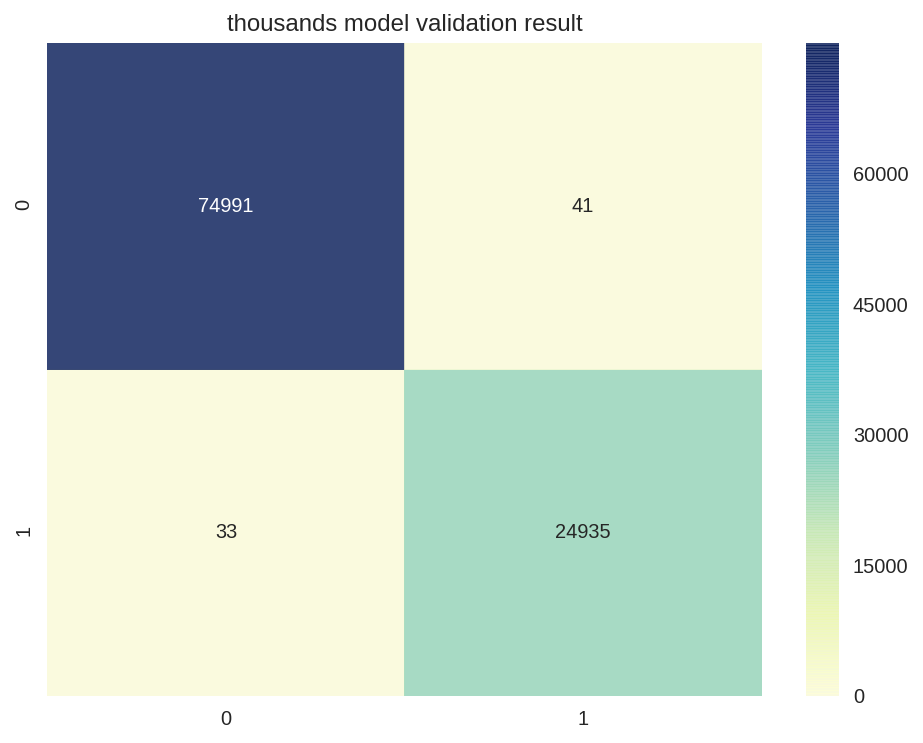

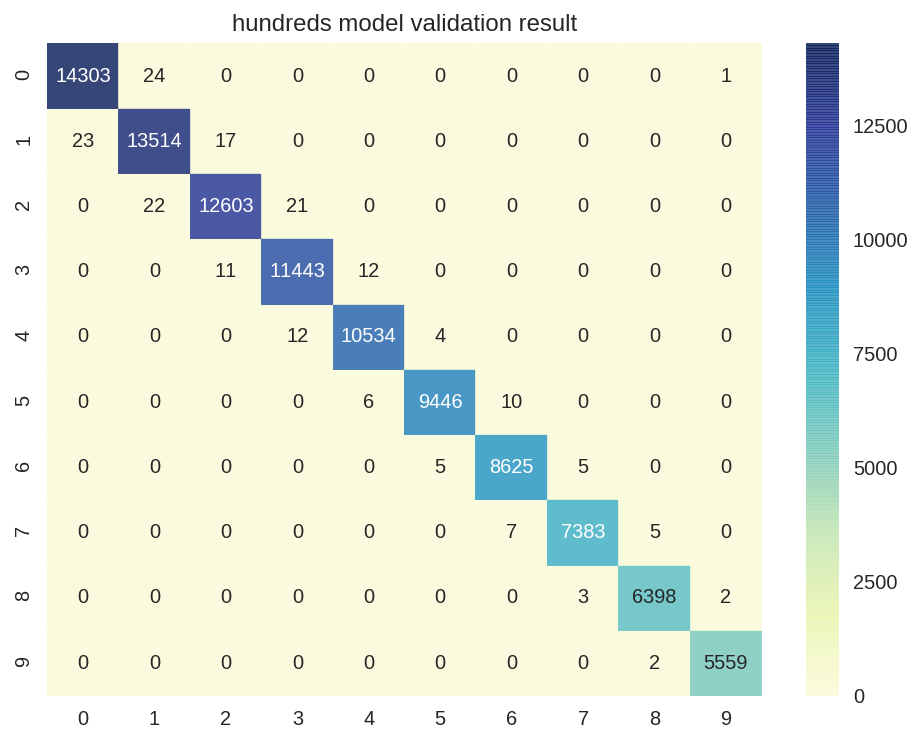

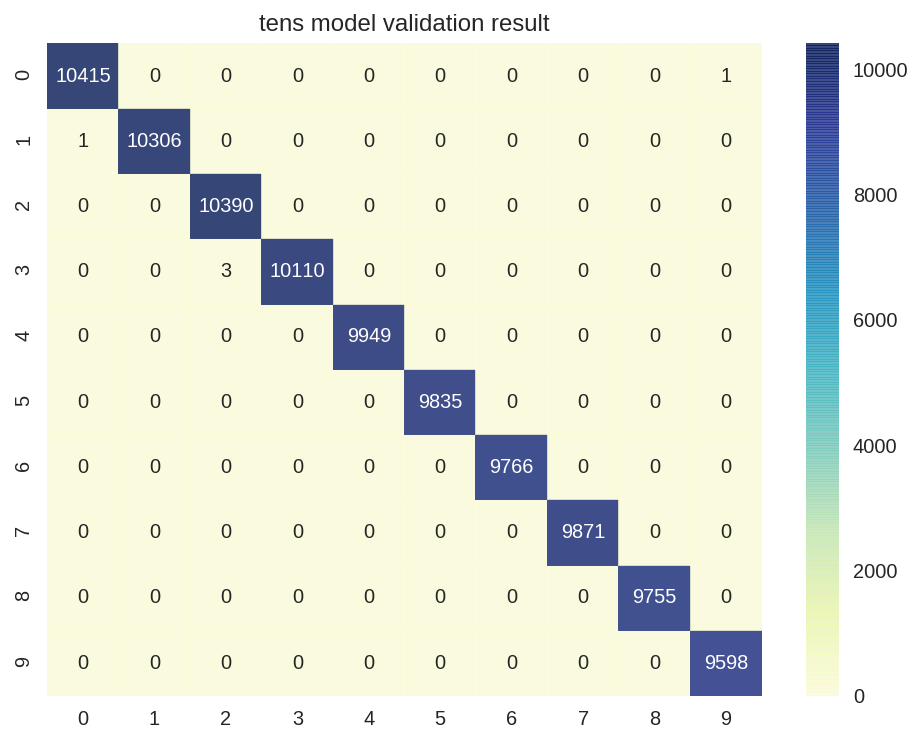

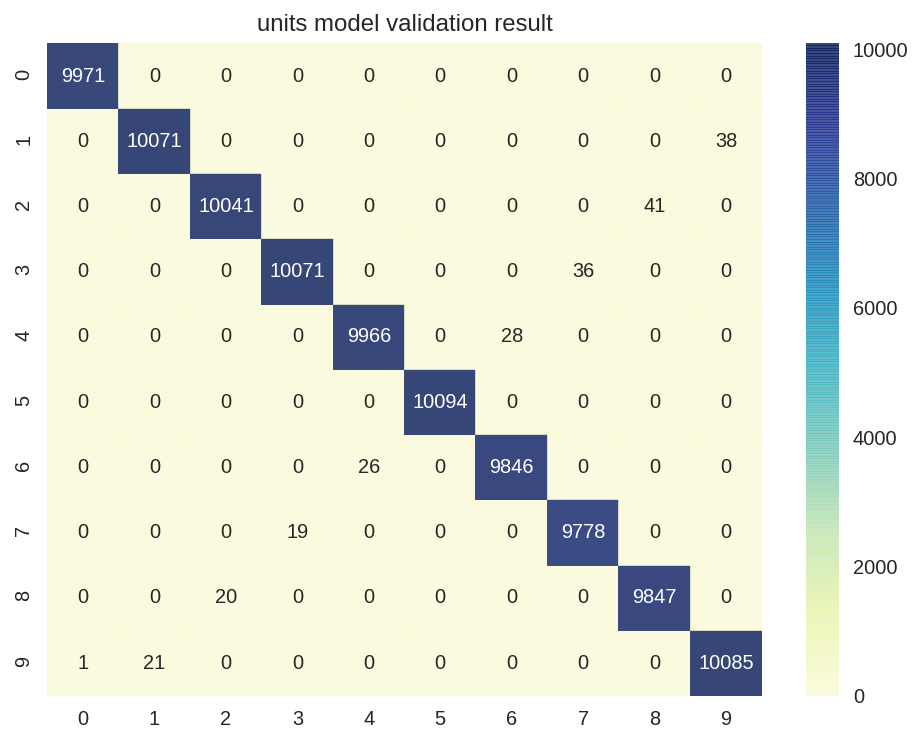

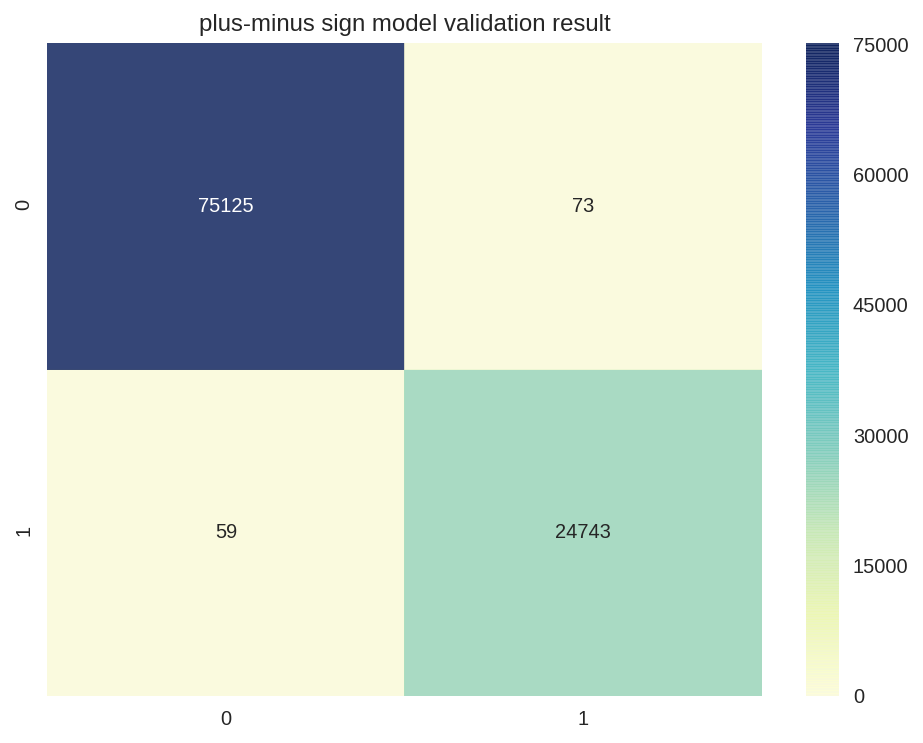

In [182]:
# Get the testing data
test_X, test_Y = loadTestData()
test = test_X
test_X = flatten(encoding(test_X))

# Validate models
modelValidation(test_X, test_Y)

# Calculate the accuract on testing data
print("Training Data: ")
dataRepresentation(train)
print("")

print("Validation Data: ")
dataRepresentation(test)